# 패키지 와 데이터 로드

In [78]:
import time
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn_extra.cluster import KMedoids

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Komoran

import pandas_datareader as pdr
from datetime import datetime

from scipy.cluster.hierarchy import linkage 
from scipy.cluster.hierarchy import dendrogram 

from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

import scipy.spatial.distance as ssd

from gensim.models import Word2Vec as w_to_v

In [79]:
#df.to_pickle('C:/Users/Dohyung/Desktop/데이터 마이닝/데이터 마이닝_프로젝트/ipynb/name,code,x1,x2,x3,x,x_nonumber,morph,morph_sum,labels_kse,labels_fics.fkl')
#df = pd.read_pickle('./name,code,x1,x2,x3,x,x_nonumber,morph,morph_sum,labels_kse,labels_fics.fkl')
df = pd.read_csv('./df.csv', encoding = 'euc-kr')
df_price = pd.read_pickle('./price_normal.fkl')
df_dtw_matrix = pd.read_pickle('./dtw_matrix.fkl')

df_finance = pd.read_pickle('./financial_i_log_categoric.fkl')
#df_finance = pd.read_csv('C:/Users/Dohyung/Desktop/데이터 마이닝/데이터 마이닝_프로젝트/Excel/financial_i.csv', encoding = 'euc-kr') #직접 수정본, log 스케일

df_word = pd.read_csv('C:/Users/Dohyung/Desktop/데이터 마이닝/데이터 마이닝_프로젝트/Excel/khaiii_parsing.csv', encoding = 'euc-kr') #fnguide
df_dart = pd.read_csv('./dart.csv', encoding = 'euc-kr')
df_dart_origin = pd.read_pickle('./dart_crawling_result.fkl')
df_price = df_price.dropna(axis = 0)

In [ ]:
df['labels_kse'].unique()

# 재무 지표 데이터 클러스터링

In [ ]:
#Kmeans
finance_data = df_finance[["PER", "PBR", "PCR", "EV/EBITDA", "Dividend"]]
clst = KMeans(n_clusters=5)
clst.fit(finance_data)


clusters = clst.labels_.tolist()

centers = clst.cluster_centers_

In [ ]:
# elbow 

clusters_range = list(range(2, 15))
inertia = []

for i in list(range(2, 15)):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(finance_data)
    inertia.append(kmeans.inertia_)

sns.scatterplot(x=clusters_range, y=inertia)

In [ ]:
# 실루엣.....?
# https://steadiness-193.tistory.com/285

from sklearn.metrics import silhouette_score

k_range = range(2, 15)
best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 100)
    kmeans.fit(finance_data)
    clusters = kmeans.predict(finance_data)
    
    score = silhouette_score(finance_data, clusters)
    print('k :', k, 'score :', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n :', best_n, 'best score :', best_silhouette_score)

In [ ]:
# PCA 차원 축소
%matplotlib notebook
using_pca = PCA(n_components=3)
using_pca.fit(finance_data)
pca= using_pca.transform(finance_data)
centers_trans= using_pca.transform(centers)

xs, ys, zs = pca[:, 0], pca[:, 1], pca[:, 2]

df_plot = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters))
groups = df_plot.groupby('label')


fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.margins(0.05)
colors = {0:'r', 1: 'b', 2: 'k', 3: 'm', 4: 'c', 5: 'g', 6: 'w'}
for idx, group in groups:
    ax.plot(group.x, group.y, group.z ,marker='o', linestyle='', ms=5, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    ax.tick_params(        axis= 'z',
        which='both',
        left='off',
        top='off',
        labelleft='off')



ax.plot(centers_trans[:,0],centers_trans[:,1],centers_trans[:,2], c='y', zorder=100, marker='d', linestyle='')
plt.show()

# 토큰화

In [ ]:
# !토크나이징
# 핵심

morphs=[]

komoran = Komoran(userdic='./my_dict.txt')
string_list = []
for i in range(0,200):
    noun = komoran.nouns(df_dart.iloc[i]['x2']) #morphs 로 하면, 형태소 단위로 다 쪼갬
    morphs.append(noun)
for j in range(0,200):
    every_morphs = komoran.pos(df_dart.iloc[j]['x2'])
    english = []
    for k in every_morphs:
        if k[1] == 'SL':
            english.append(k[0])

    morphs[j] += english

df_dart["morph"]= morphs






for i in range(0,200):
    sum_string = ""
    for j in range(0,len(df_dart.iloc[i]["morph"])):
        sum_string+= (df_dart.iloc[i]["morph"][j]+ " ")
    string_list.append(sum_string)
    
df_dart["morph_sum"] = string_list
df_dart

In [ ]:
with_dart = []
df_dartcopy = df_dart.copy()
df_copy = df.copy()

for i in range(0,200):
    A = df_dartcopy.iloc[i]["morph_dart"]
    B = df_copy.iloc[i]["morph_sum"]
    with_dart.append(A+B)
    
df["morph_sumdart"] = with_dart
df

# 기업 개요 데이터 클러스터링

In [92]:
#TFidf 변환 및 KMeans 학습

countvectorizer = CountVectorizer(stop_words=['1월', '1일','2월','3월','4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월', 'M', 'co', 'company', 'global', 'inc', '가능', '가능', '가치', '각종', 
                                              '감소', '강화', '개', '개선', '개시', '개요', '거점', '결과', '결정', '경영', 
                                              '경우', '경쟁력', '계속', '계획', '공시', '과정', '관련', '관리', '구분', 
                                              '구성', '구조', '구축', '국가', '국내', '국내외', '규모', '극대', '글로벌', 
                                              '기간', '기능', '기대', '기록', '기반', '기업', '기존', '기준', '기초',
                                              '기타', '기회', '내용', '노력', '누적', '능력', '다각', '다수', '다양', '다음',
                                              '단계', '단위', '단일', '달성', '담당', '당기', '당사', '대비', '대상', '대응',
                                              '도약', '도입', '동기', '동력', '동사', '동시', '드', '등', '마련', '매출', 
                                              '매출액', '목적', '목표', '및', '바탕', '반기', '반영', '방식', '법인', '변경',
                                              '변동', '변화', '별도', '보수', '보호', '부가', '부문', '부분', '분기', '분류',
                                              '분야', '비용', '비중', '사업', '사업장', '사용', '사항', '상기', '상반기', 
                                              '상승', '상장', '상호', '상황', '선도', '설계', '설립', '설비', '성격', '성장',
                                              '세계', '소유', '수요', '수익', '수준', '수출', '수행', '시작', '시장', '시행',
                                              '실적', '아래', '안정', '업무', '업체', '역량', '역할', '연간', '연결', '영역', 
                                              '영업', '영위', '영향', '예상', '예정', '완료', '요구', '요약', '요인', '우수', 
                                              '우위', '운영', '위주', '위치', '유가증권', '유지', '의', '이상', '이익', '이하', 
                                              '이후', '일반', '일부', '임대', '입지', '자금', '자본', '자산', '자체', '작성', 
                                              '장기', '장벽', '장점', '재무', '적극', '적용', '전개', '전년', '전년 동기', 
                                              '전략', '전망', '전문', '전반', '전체', '점유', '제고', '제외', '제품', '조정', '조직', 
                                              '종속', '종합', '주', '주도', '주력', '주식', '주식회사', '주요', '준비', '중심',
                                              '중요', '증가', '증대', '지배', '지분', '지속', '지역', '지원', '지위', '지주',
                                              '지주회사', '진행', '집중', '차별', '차지', '참고', '참여', '참조', '창출',
                                              '채널', '처리', '체계', '체제', '최고', '최근', '최대', '최소', '최초',
                                              '추가', '추세', '추진', '충족', '투자', '특성', '특수', '특징', '평가',
                                              '포함', '필요', '항목', '해당', '해외', '핵심', '향상', '향후', '현재', '현지',
                                              '현황', '형태', '확대', '확보', '확장', '활동', '활용', '회사', '효율'], 
                                  ngram_range=(1,2), max_df = 0.6, min_df = 0.05, lowercase=True) #0.4 0.05
tfidftransformer = TfidfTransformer()

data = df["morph_sumdart"].copy()
data_trans = tfidftransformer.fit_transform(countvectorizer.fit_transform(data))


clst = KMeans(n_clusters=12, random_state=0)
clst.fit(data_trans)


clusters = clst.labels_.tolist()

centers = clst.cluster_centers_

In [93]:
print(data_trans.shape)

(200, 731)


In [94]:
countvectorizer.stop_words_

{'마트 가전제품',
 '소비 pg',
 'ib investment',
 '즉시 납입',
 '텐트',
 '원양항 선박',
 '건축물 개발',
 '서울 광화문빌딩',
 '성유 제조',
 '조건 adnoc',
 '스트리밍',
 '장대교량',
 '법률 규정',
 '제도 확립',
 '영업망 인지도',
 '박차 트랜드',
 '수익원 다각화',
 '실시 내부',
 '제작 설치',
 'market 초창기',
 '원자로',
 '회사명소재국사업개요위버스컴퍼니대 한민국',
 '성공 pc',
 '지식 서비스',
 '오픈라인 매장',
 'bi 시스템',
 '전산 시스',
 '임상 파이프라인',
 '플래쉬 메모리',
 '용품 소비재',
 '자원 석회',
 '고관리 도모',
 '정비 다기종',
 '상시 인력',
 '기술 제한',
 '기재부',
 '하동',
 '화력 멕시코',
 '얀센 기술',
 '전공',
 '조화 시스템',
 '기여 선망',
 '균형 추구',
 '선정 중점',
 '경쟁 정비',
 '매트리스 분석',
 '휴대 전화',
 '정부 인허가',
 '쇼크 실제',
 '바탄',
 '페이저',
 '오스트리아',
 '대죄 grand',
 '미생물',
 '공기구',
 '개요하이브 대한민국',
 '영풍 japan',
 '판매 통사업부',
 '생물',
 'restasis',
 '복합 분산',
 '기관 아파트',
 '방산 최종',
 '국의 현대',
 'gs25',
 '성장세 부동산',
 '신규 물류',
 '은행 대출',
 '세분 성숙기',
 '이스라엘 조치',
 'tdi 추정',
 '소재 비료',
 '설치 총원가',
 '통지',
 '서비스 공급',
 '원유 수입',
 '순이익 매각',
 '고려 최적',
 '외형 경기',
 '사료 사료',
 '정보 통신',
 '시설 건물',
 '기술 미국',
 '중량물 프로젝트',
 'gartner it',
 '실리콘 생산',
 '래엠 기재',
 '장려 디지털',
 '관광업 특허',
 '츄정',
 '사람 기호',
 '개발 호주',
 'quality servic

In [95]:
countvectorizer.vocabulary_

{'본사': 259,
 '한국': 689,
 '전자': 532,
 'tv': 23,
 '스마트폰': 370,
 '네트워크': 149,
 '시스템': 377,
 '부품': 269,
 '모바일': 208,
 '반도체': 228,
 '디스플레이': 187,
 '인수': 484,
 '디지털': 189,
 '삼성': 293,
 '대리점': 161,
 '전담': 526,
 '서비스': 314,
 '운송': 437,
 '유럽': 456,
 '중동': 577,
 '아시아': 397,
 '연구': 415,
 '미국': 219,
 '복합': 256,
 'sk': 21,
 '가전': 33,
 '중국': 575,
 'vietnam': 24,
 '상세': 296,
 '매출처': 205,
 '생산 판매': 310,
 '현대': 704,
 '산업': 288,
 '사명': 284,
 'lg': 11,
 '합병': 693,
 '그룹': 119,
 '편입': 671,
 '독일': 176,
 '일본': 493,
 '인도': 481,
 '대만': 162,
 '설치': 330,
 '시설': 376,
 '정보': 542,
 '저장': 519,
 '반면': 229,
 '소재': 347,
 '준공': 574,
 '누계': 151,
 'ii': 7,
 '진출': 593,
 '생산 시설': 309,
 '생산 생산': 308,
 '혁신': 702,
 '도전': 174,
 '첨단': 609,
 '기술': 133,
 '경험': 74,
 '제공': 549,
 '환경': 719,
 '동안': 182,
 '신규': 380,
 '선제': 327,
 '인터넷': 491,
 '광고': 108,
 '커머스': 636,
 '콘텐츠': 640,
 '금융': 125,
 '솔루션': 352,
 '포트폴리오': 674,
 '성장세': 335,
 '한편': 691,
 '수주': 365,
 '쇼핑': 354,
 '공공': 93,
 '인프라': 492,
 '보유': 252,
 '솔루션 제공': 353,
 '바이오': 226,
 '의약품'

In [36]:
#동헌 버전
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=["동사", "및", "의", "등", "부문", "주","상장","주요","설립"], ngram_range=(1,1) , min_df = 0.01, max_df = 0.5).fit(data)
tfidf_matrix = tfidf.transform(data).toarray()
tfidf_vect = tfidf.fit_transform(data) # https://techblog-history-younghunjo1.tistory.com/114 --> tfidf vector를 모델에 input으로

In [ ]:
# quantile : 데이터 개수의 일정 비율만큼 샘플링하면서 meanshift하게됨
# 따라서, 데이터 개수가 엄청 많아질시 quantile값이 적으면 시간이 너무 오래걸림
bandwidth = estimate_bandwidth(tfidf_matrix, quantile=0.25)
print("최적의 bandwidth 값:", round(bandwidth, 3))

In [ ]:
#Meanshift

meanshift = MeanShift(bandwidth=1.385)
#, cluster_all = False, bin_seeding=True
meanshift.fit(tfidf_matrix)

clusters = meanshift.labels_.tolist()
centers = meanshift.cluster_centers_
print('centers의 개수:', centers.shape[0])

<IPython.core.display.Javascript object>


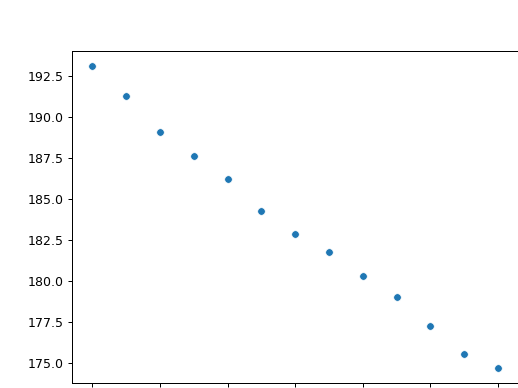

<AxesSubplot:>

In [65]:
# elbow --> 엘보우 포인트가 확실하지 않음

clusters_range = list(range(2, 15))
inertia = []

for i in list(range(2, 15)):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(data_trans)
    inertia.append(kmeans.inertia_)

sns.scatterplot(x=clusters_range, y=inertia)

In [38]:
# 실루엣.....?
# https://steadiness-193.tistory.com/285

from sklearn.metrics import silhouette_score

k_range = range(2, 25)
best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 100)
    kmeans.fit(data_trans)
    clusters = kmeans.predict(data_trans)
    
    score = silhouette_score(data_trans, clusters)
    print('k :', k, 'score :', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n :', best_n, 'best score :', best_silhouette_score)

k : 2 score : 0.03657841801662442
k : 3 score : 0.053717449088853016
k : 4 score : 0.06454500038394592
k : 5 score : 0.06496647133414607
k : 6 score : 0.06871670631602414
k : 7 score : 0.07482299887422876
k : 8 score : 0.07262275738029732
k : 9 score : 0.07777274881943647
k : 10 score : 0.07597829416365993
k : 11 score : 0.07791418770191903
k : 12 score : 0.08068469096029257
k : 13 score : 0.08796245990955268
k : 14 score : 0.08407816173812441
k : 15 score : 0.07529789874487557
k : 16 score : 0.08485715602050765
k : 17 score : 0.08191048452195662
k : 18 score : 0.08068056891702106
k : 19 score : 0.08362596692192614
k : 20 score : 0.07685259152955294
k : 21 score : 0.08143122191440476
k : 22 score : 0.08234478716368375
k : 23 score : 0.08514098857515101
k : 24 score : 0.08487505490740867
best n : 13 best score : 0.08796245990955268


In [ ]:
#계층적 클러스터링(강의버젼)

hac = linkage(tfidf_matrix, 'ward') #single, average, complete, weighted, centroid, median, ward
plt.figure(figsize=(10, 7))
labelList = range(1,201)
dendrogram(hac,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

<IPython.core.display.Javascript object>


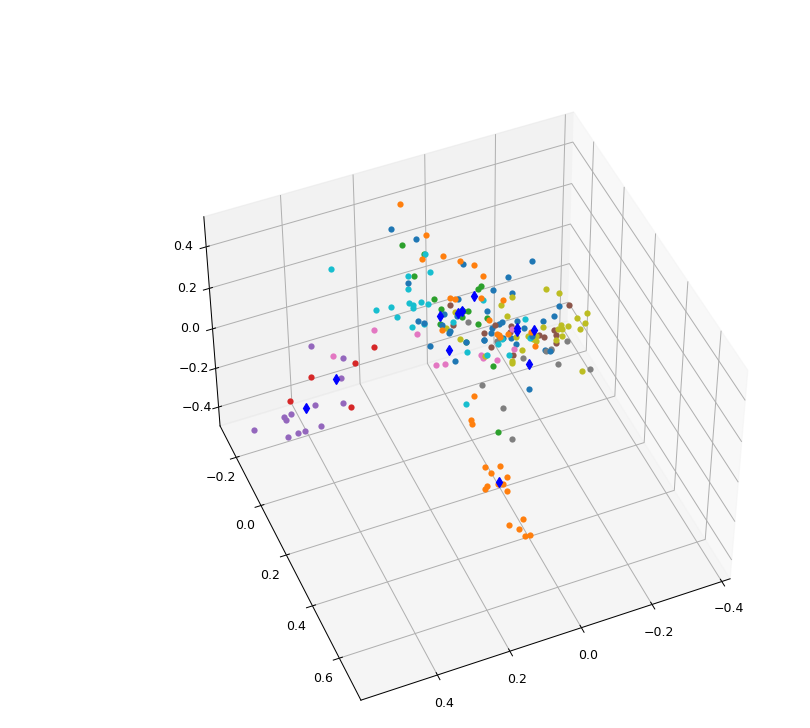

In [96]:
# PCA 차원 축소
#%matplotlib notebook
using_pca = PCA(n_components=3)
using_pca.fit(data_trans.toarray())
pca= using_pca.transform(data_trans.toarray())
centers_trans= using_pca.transform(centers)

xs, ys, zs = pca[:, 0], pca[:, 1], pca[:, 2]

df_plot = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters))
groups = df_plot.groupby('label')


fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.margins(0.05)
colors = {0:'r', 1: 'b', 2: 'k', 3: 'm', 4: 'c', 5: 'g', 6: 'w'}
for idx, group in groups:
    ax.plot(group.x, group.y, group.z ,marker='o', linestyle='', ms=5, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    ax.tick_params(        axis= 'z',
        which='both',
        left='off',
        top='off',
        labelleft='off')



ax.plot(centers_trans[:,0],centers_trans[:,1],centers_trans[:,2], c='b', zorder=100, marker='d', linestyle='')
plt.show()

In [97]:
# 데이터 프레임 형태로 클러스터 결과 확인

df["cluster"]= clusters

df_groupby_cluster = df.groupby('cluster')
#result = dict(list((df_groupby_cluster['name'])))

groupby_list = df.groupby('cluster')['labels_kse'].apply(list)

for i in groupby_list:
    print(i)
    print('\n')


['기계', '화학', '건설업', '서비스업', '전기,전자', '금융업', '운수장비', '건설업', '화학', '건설업', '운수장비', '건설업', '서비스업', '건설업', '건설업', '금융업', '비금속광물']


['의약품', '의약품', '서비스업', '금융업', '의약품', '의약품', '의약품', '금융업', '의약품', '서비스업', '의약품', '의약품', '화학', '의약품', '의약품', '의약품', '의약품']


['유통업', '화학', '화학', '음식료품', '의약품', '화학', '음식료품', '유통업', '유통업', '유통업', '음식료품', '화학', '섬유,의복', '화학', '유통업', '섬유,의복']


['보험', '보험', '보험', '보험', '보험']


['은행', '금융업', '금융업', '금융업', '금융업', '은행', '증권', '금융업', '증권', '증권', '증권', '금융업', '증권']


['운수장비', '운수장비', '운수장비', '전기,전자', '기계', '서비스업', '전기,전자', '운수장비', '기계', '유통업', '운수장비', '유통업', '운수장비', '화학']


['전기가스업', '전기,전자', '금융업', '화학', '유통업', '화학', '제조업', '철강및금속', '유통업', '기계']


['전기,전자', '화학', '전기,전자', '화학', '금융업', '금융업', '비금속광물', '화학', '전기,전자', '화학', '화학', '금융업']


['전기,전자', '제조업', '철강및금속', '운수장비', '철강및금속', '화학', '화학', '화학', '화학', '비금속광물', '기계', '화학', '화학', '화학', '운수장비', '금융업', '기계', '음식료품', '금융업', '화학', '철강및금속', '전기,전자', '서비스업', '제조업', '철강및금속', '화학', '화학', '금융업', '음식료품']


['전기,전자', '서비스업', '서비스업',

In [98]:
# 데이터 프레임 형태로 클러스터 결과 확인

df["cluster"]= clusters

df_groupby_cluster = df.groupby('cluster')
#result = dict(list((df_groupby_cluster['name'])))

groupby_list = df.groupby('cluster')['name'].apply(list)

for i in groupby_list:
    print(i)
    print('\n')

['두산중공업', 'S-Oil', '현대건설', '삼성엔지니어링', '일진머티리얼즈', 'GS', '삼성중공업', 'GS건설', 'OCI', '대우건설', '현대로템', 'DL이앤씨', '한전기술', '한전KPS', 'HDC현대산업개발', 'DL', '아이에스동서']


['삼성바이오로직스', '셀트리온', 'SK바이오팜', '한미사이언스', '한미약품', '녹십자', '신풍제약', '대웅', '대웅제약', '녹십자홀딩스', '종근당', '한올바이오파마', '한국콜마', '보령제약', '부광약품', '영진약품', '일양약품']


['삼성물산', 'LG생활건강', '아모레퍼시픽', '오리온', '유한양행', '아모레G', '하이트진로', '신세계', '휠라홀딩스', '영원무역', '농심', '동원시스템즈', 'F&F;홀딩스', '코스맥스', '신세계인터내셔날', '한섬']


['삼성생명', '삼성화재', 'DB손해보험', '한화생명', '현대해상']


['카카오뱅크', 'KB금융', '신한지주', '하나금융지주', '우리금융지주', '기업은행', '미래에셋증권', '한국금융지주', '삼성증권', 'NH투자증권', '메리츠증권', 'BNK금융지주', '키움증권']


['현대차', '기아', '현대모비스', 'LG전자', '한온시스템', '코웨이', 'LG이노텍', '만도', '씨에스윈드', '한샘', '현대위아', '현대그린푸드', 'SNT모티브', 'LX하우시스']


['한국전력', 'LG디스플레이', '삼성카드', '효성티앤씨', '현대백화점', '대한유화', '화승엔터프라이즈', '풍산', '현대홈쇼핑', '현대두산인프라코어']


['SK하이닉스', 'LG화학', '삼성SDI', 'SK이노베이션', 'SK', 'LG', '포스코케미칼', 'SKC', '두산퓨얼셀', 'SK케미칼', '후성', 'SK디스커버리']


['SK아이이테크놀로지', 'KT&G;', '고려아연', '한국조선해양', '현대제철', '금호석유', '한국타이어앤테크놀로지', '현

In [ ]:
#LDA 차원축소
lda = LinearDiscriminantAnalysis(n_components=3)

#학습
lda.fit(data_trans.toarray(), clusters)
#변형
data_lda = lda.transform(data_trans.toarray())
centers_trans= lda.transform(centers)

#DataFrame 생성
lda_columns=['lda_component_1','lda_component_2','lda_component_3']
DF_lda = pd.DataFrame(data_lda, columns=lda_columns)
DF_lda['target']=clusters


#축 지정
xs, ys, zs = data_lda[:, 0], data_lda[:, 1], data_lda[:, 2]

df_plot = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters))
groups = df_plot.groupby('label')

markers=['^', 's', 'o','d','*']
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.margins(0.05)
colors = {0:'r', 1: 'b', 2: 'k', 3: 'm', 4: 'c', 5: 'g', 6: 'w'}
for idx, group in groups:
    ax.plot(group.x, group.y, group.z ,marker='o', linestyle='', ms=5, mec='none' )
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    ax.tick_params(        axis= 'z',
        which='both',
        left='off',
        top='off',
        labelleft='off')



ax.plot(centers_trans[:,0],centers_trans[:,1],centers_trans[:,2], c='y', zorder=100, marker='d', linestyle='')
plt.show()



# 주가 변동 데이터 클러스터링

## 클러스터링 알고리즘 선택

In [4]:
#시계열 KMeans
n_clusters = 20
tsclst = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean') #'euclidean', 'dtw'
tsclst.fit(df_price)

clusters = tsclst.labels_.tolist()

centers = tsclst.cluster_centers_

In [ ]:
# elbow 

clusters_range = list(range(2, 25))
inertia = []

for i in list(range(2, 25)):
    tskmeans = TimeSeriesKMeans(n_clusters = i, metric='euclidean')
    tskmeans.fit(df_price)
    inertia.append(tskmeans.inertia_)

sns.scatterplot(x=clusters_range, y=inertia)

In [ ]:
sns.scatterplot(x=clusters_range, y=inertia)

In [ ]:
len(tsclst.labels_)

In [ ]:
# 실루엣.....?
# https://steadiness-193.tistory.com/285

from sklearn.metrics import silhouette_score

k_range = range(2, 10)
best_n = -1
best_silhouette_score = -1

for k in k_range:
    stskmeans = TimeSeriesKMeans(n_clusters = k, metric = 'euclidean')
    stskmeans.fit(df_price)
    clusters = stskmeans.labels_
    
    score = silhouette_score(df_price, labels = clusters)
    print('k :', k, 'score :', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n :', best_n, 'best score :', best_silhouette_score)

<IPython.core.display.Javascript object>


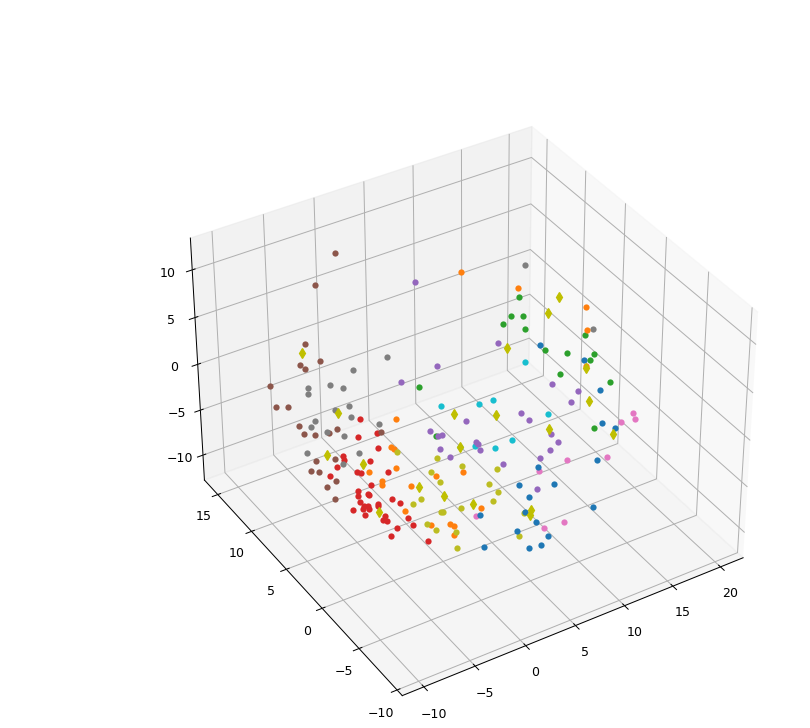

In [5]:
%matplotlib notebook
#pca 차원축소
using_pca = PCA(n_components=3)
using_pca.fit(df_price)
pca= using_pca.transform(df_price)
centers_trans= using_pca.transform(centers.reshape(n_clusters,248))

xs, ys, zs = pca[:, 0], pca[:, 1], pca[:, 2]

df_plot = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters))
groups = df_plot.groupby('label')


fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.margins(0.05)
colors = {0:'r', 1: 'b', 2: 'k', 3: 'm', 4: 'c', 5: 'g', 6: 'w',-1:'y'}
for idx, group in groups:
    ax.plot(group.x, group.y, group.z ,marker='o', linestyle='', ms=5, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    ax.tick_params(        axis= 'z',
        which='both',
        left='off',
        top='off',
        labelleft='off')



ax.plot(centers_trans[:,0],centers_trans[:,1],centers_trans[:,2], c='y', zorder=100, marker='d', linestyle='')
plt.show()

<IPython.core.display.Javascript object>


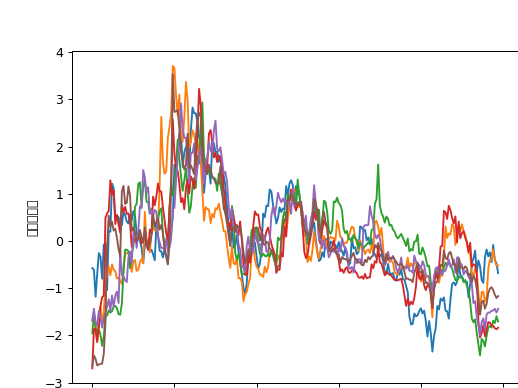

In [29]:
df_price["cluster"] = clusters
index = []
cluster0 = df_price.query("cluster==2")
cluster0 = cluster0.drop("name", axis=1, errors = 'ignore')
cluster0 = cluster0.drop("cluster", axis=1, errors = 'ignore')
for i in range(0, len(cluster0)):
    sns.lineplot(y = cluster0.iloc[i], x = list(range(248)))


<IPython.core.display.Javascript object>


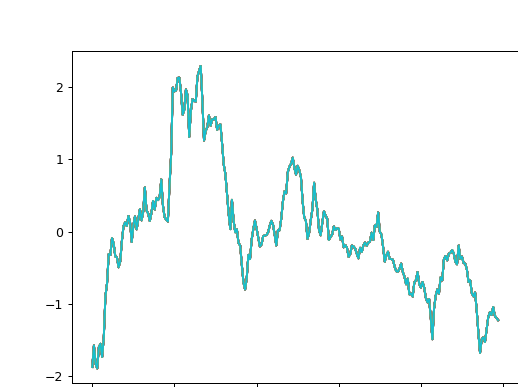

In [30]:
centers_price = centers.reshape(n_clusters,248)
for i in range(0, n_clusters):
    sns.lineplot(y = centers_price[2], x = list(range(248)))
    

In [7]:
# 데이터 프레임 형태로 클러스터 결과 확인

df_price["cluster"]= clusters
df_price["name"]= df_price.index

df_groupby_cluster = df_price.groupby('cluster')
#result = dict(list((df_groupby_cluster['name'])))

groupby_list = df_price.groupby('cluster')["name"].apply(list)

for i in groupby_list:
    print(i)
    print('\n')
df_price = df_price.drop("name",axis=1, errors = 'ignore')
df_price = df_price.drop("cluster",axis=1, errors = 'ignore')

['SK하이닉스', '롯데케미칼', '오리온', '동서', 'F&F;홀딩스', '대한유화']


['대한항공', 'OCI', '한화생명', 'BGF리테일', '신세계', '영원무역', '현대백화점', '롯데칠성', '롯데관광개발', '신세계인터내셔날', 'CJ CGV', 'LX인터내셔널', '한섬', 'GKL', '현대그린푸드', '쿠쿠홀딩스']


['한화솔루션', '유한양행', '한미약품', '녹십자', '키움증권', '녹십자홀딩스']


['NAVER', '카카오', '하이브', 'S-Oil', 'KT', '현대건설', '쌍용C&E;', '팬오션', '포스코인터내셔널', '효성티앤씨', '현대로템', '한화에어로스페이스', '코스맥스', '삼양홀딩스', '넥센타이어']


['삼성전자', 'LG화학', '현대차', '현대모비스', 'SK', '삼성전기', '한온시스템', '현대글로비스', '만도', 'SNT모티브']


['삼성화재', '고려아연', 'DB손해보험', '한국가스공사', '현대해상', '롯데정밀화학', '후성', '아시아나항공', '휴켐스']


['GS리테일', 'CJ대한통운', '하이트진로', '현대두산인프라코어']


['SK케미칼', 'SK디스커버리']


['넷마블', '롯데지주', '대우조선해양', '휠라홀딩스', '농심', '이노션', '지누스', '현대홈쇼핑', '대상']


['삼성물산', '한국전력', '한미사이언스', '삼성중공업', '씨에스윈드', 'LS', '대웅', '대웅제약']


['LG', '삼성생명', '아모레퍼시픽', '한국조선해양', 'LG디스플레이', '금호석유', '아모레G', '롯데쇼핑', '한국앤컴퍼니', '아이에스동서', '한국콜마', '동원산업', '롯데하이마트']


['셀트리온', '두산퓨얼셀', '에스원', '종근당', '부광약품']


['KT&G;', 'SK바이오팜', '한진칼', '신풍제약', 'DL', '한올바이오파마', '영진약품', '삼양식품', '일양약품']


['POSCO'

In [ ]:
df_price